## Simple Rejection ABC Problem

Originally developed by Pritchard et al. (1999) following earlier ideas by Tavar ́e et al. (1997), the ABC rejection sampling algorithm [Handbook, p. 90]

#### Configure Notebook

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import os
import sys

import matplotlib.pyplot as plt
import numba
import numpy as np
import pandas as pd
from scipy.stats import norm, invgamma, gaussian_kde

from IPython.display import display
import warnings
# Comment this to turn on warnings
warnings.filterwarnings('ignore')

#plt.style.use('seaborn')
# Set fontsizes in figures
params = {'legend.fontsize': 'large',
          'axes.labelsize': 'large',
          'axes.titlesize': 'large',
          'xtick.labelsize': 'large',
          'ytick.labelsize': 'large',
          'legend.fontsize': 'large',
          'legend.handlelength': 2}
plt.rcParams.update(params)

### Conjugate Models

http://patricklam.org/teaching/conjugacy_print.pdf

### Problem

Infer the unknown variance $\sigma^2$ of a zero-mean Gaussian distribution. 

Likelihood: 

$$p (y | \sigma^2) \sim \mathrm{N}(\mu=0, \sigma^2)$$

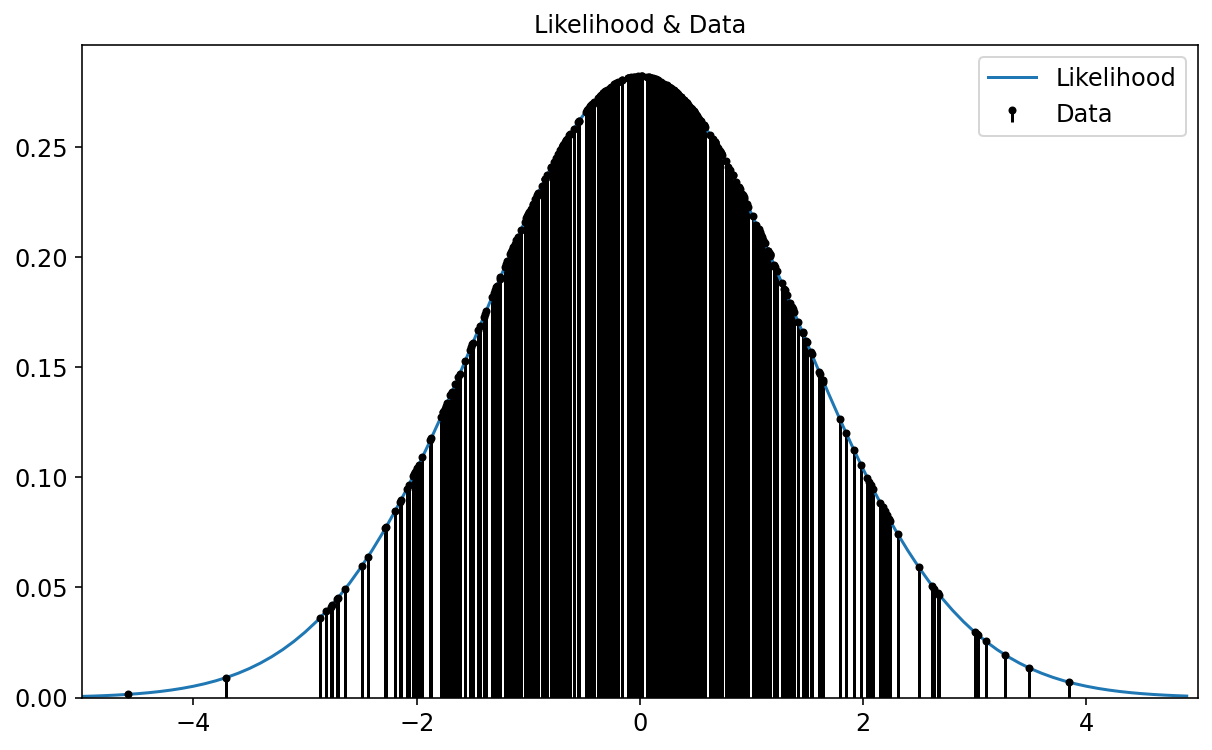

In [2]:
Nsamp = 300

groundtruth = 2.
likelihood = norm(loc=0., scale=np.sqrt(groundtruth))

(dmin,dmax) = (-5,5)
data = likelihood.rvs(size=Nsamp)
lh_data = likelihood.pdf(data)
x_arr = np.arange(dmin,dmax, (dmax-dmin) / 100.)
f_arr = likelihood.pdf(x_arr)

fig = plt.figure(figsize=(10,6))
plt.xlim([dmin, dmax])
plt.plot(x_arr, f_arr, label="Likelihood")
markerline, stemlines, baseline = plt.stem(data, lh_data, linefmt='-k', markerfmt='k.', label="Data")
baseline.set_visible(False)
plt.title("Likelihood & Data")
plt.legend()
plt.ylim(bottom=0.)
plt.show()

### Prior 

The Inverse Gamma distribution is conjugate prior for the unknown variance of a Gaussian distribution: 

$$\pi \left(\sigma^2 \right) \sim \text{Inv-Gamma}(\alpha, \beta)$$


### Posterior

The posterior is then 

$$p(\sigma^2|y) \sim \text{Inv-Gamma}(\alpha',\beta')$$ 

with

$$
\alpha'=\alpha + \frac{N_\mathrm{samp}}{2} \quad \mathrm{and} \quad \beta'=\beta+\frac{1}{2} \sum_k y_k^2 .
$$

In [3]:
alpha = 60
beta = 130
prior = invgamma(alpha, loc=0, scale=beta)

alphaprime = alpha + Nsamp / 2
betaprime = beta + 0.5 * np.sum(data**2)
posterior = invgamma(alphaprime, loc=0, scale=betaprime)

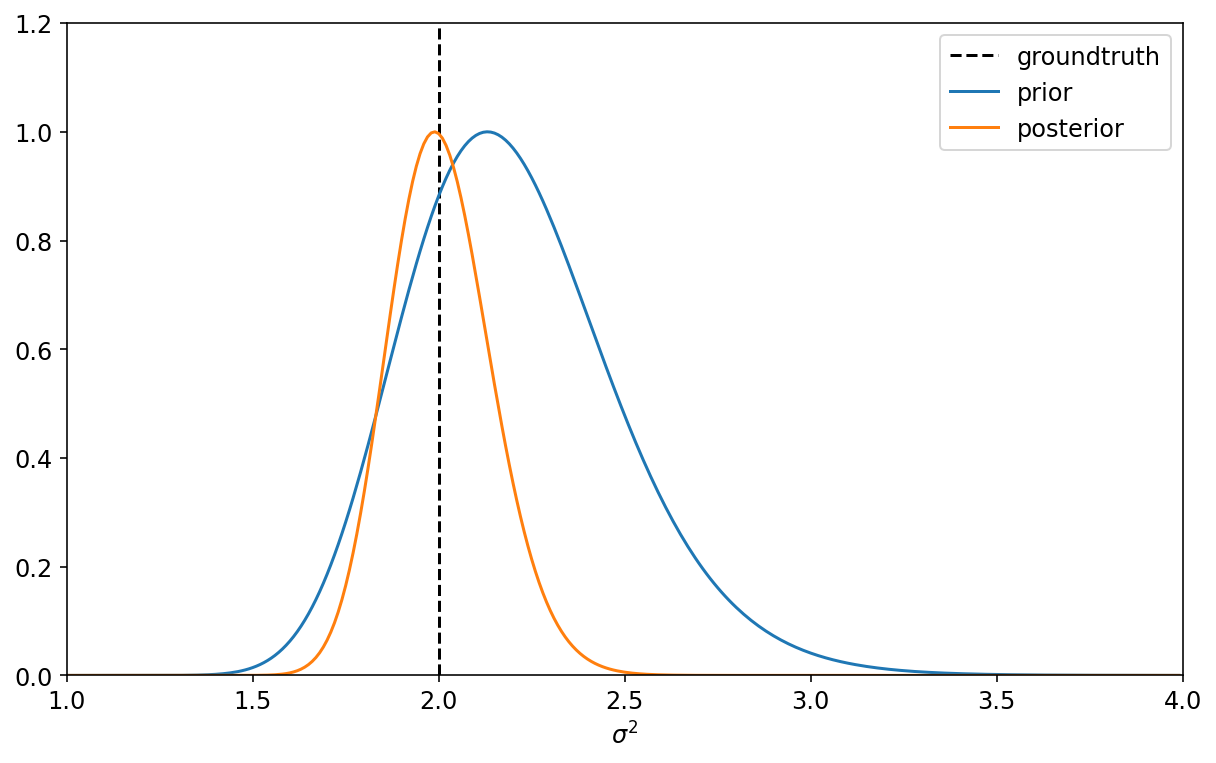

In [4]:
a = 1
b = 4
x = np.arange(a, b, 0.01)

plt.figure(figsize=(10,6))
plt.xlim([a, b])
plt.xlabel("$\sigma^2$")
plt.ylim([0, 1.2])
plt.plot([groundtruth, groundtruth], [0, 1.2], linestyle='--', color='black', label="groundtruth")
plt.plot(x, prior.pdf(x)/prior.pdf(x).max(), label="prior")
plt.plot(x, posterior.pdf(x)/posterior.pdf(x).max(), label="posterior")
plt.legend()
plt.show()

### Rejection ABC

Given a parameter $\sigma^2$ drawn from the prior, the simulator generates $N_\mathrm{samp}$ samples from a Gaussian with mean $0$ and variance $\sigma^2$. 

The distance $\rho$ between a simulation $s$ and real data $d$ is

$$\rho(s,d)=\sqrt{\left(s-d\right)^2},$$

or

$$\rho(s,d)=\sqrt{\left(S(s)-S(d)\right)^2},$$

where $S$ is a summary statistic of $s$ or $d$.

In [5]:
def simulator(var):
    return norm(loc=0., scale=np.sqrt(var)).rvs(size=Nsamp)

def distance(sim, data):
    return np.sqrt(np.sum((sim - data)**2))

### Sufficient summary statistics

Sufficient summary statistic: the estimated variance in this case

In [6]:
def sufficient_summary_stat(data):
    return np.var(data)

In [7]:
data_ss = sufficient_summary_stat(data)
print(data_ss)

1.9308168533690324


### Likelihood-free rejection sampler 

(We never call the likelihood function)

In [8]:
Nsims = 10000
epsilon = 0.5  # threshold
samples = []

# Rejection ABC algorithm
for trial in range(Nsims):
    # draw from prior
    var_trial = prior.rvs(size=1) 
    
    # call simulator
    sim_trial = simulator(var_trial) 
    
    # summary statistic
    sim_ss = sufficient_summary_stat(sim_trial)
    
    # distance less than threshold?
    reject_bool = distance(sim_ss, data_ss) < epsilon
    
    # keep or discard simulation
    if reject_bool:
        samples.append(var_trial)

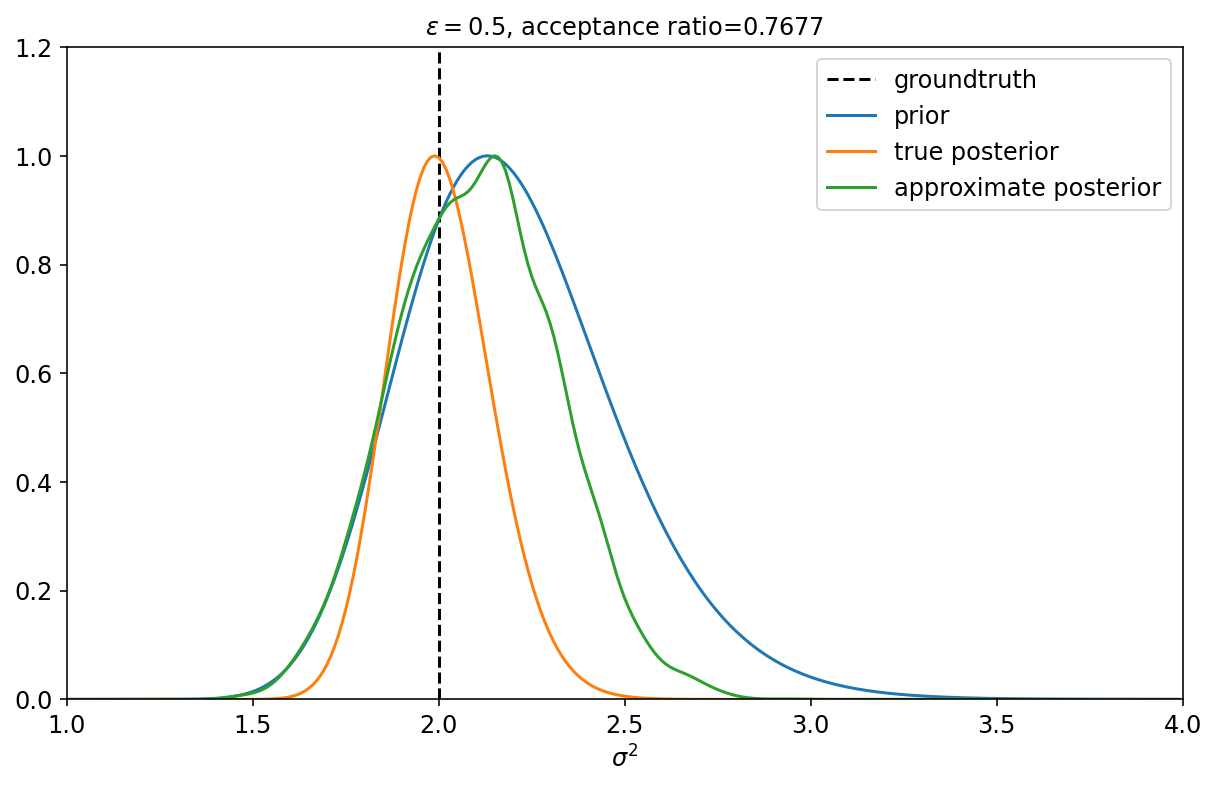

In [9]:
samples = np.array(samples).T[0]
fraction_accepted = float(len(samples)) / Nsims

# kernel density estimation of the approximate posterior
kernel = gaussian_kde(samples)

# produce a plot
plt.figure(figsize=(10, 6))
plt.xlim([a, b])
plt.xlabel("$\sigma^2$")
plt.ylim([0, 1.2])
plt.plot([groundtruth, groundtruth],[0, 1.2], linestyle='--', color='black', label="groundtruth")
plt.plot(x, prior.pdf(x)/prior.pdf(x).max(), label="prior")
plt.plot(x, posterior.pdf(x)/posterior.pdf(x).max(), label="true posterior")
plt.plot(x, kernel.evaluate(x)/kernel.evaluate(x).max(), label="approximate posterior")
plt.title("$\\varepsilon=" + str(epsilon) + "$, acceptance ratio=" + str(fraction_accepted))
plt.legend()
plt.show()

### Different thresholds

In [10]:
def rejection_abc(epsilon, Nsims):
    samples = []
    for trial in range(Nsims):
        # draw from prior
        var_trial = prior.rvs(size=1) 

        # call simulator
        sim_trial = simulator(var_trial) 

        # summary statistic
        sim_ss = sufficient_summary_stat(sim_trial)

        # distance less than threshold?
        reject_bool = distance(sim_ss, data_ss) < epsilon

        # keep or discard simulation
        if reject_bool:
            samples.append(var_trial)
            
    return np.array(samples).T[0]

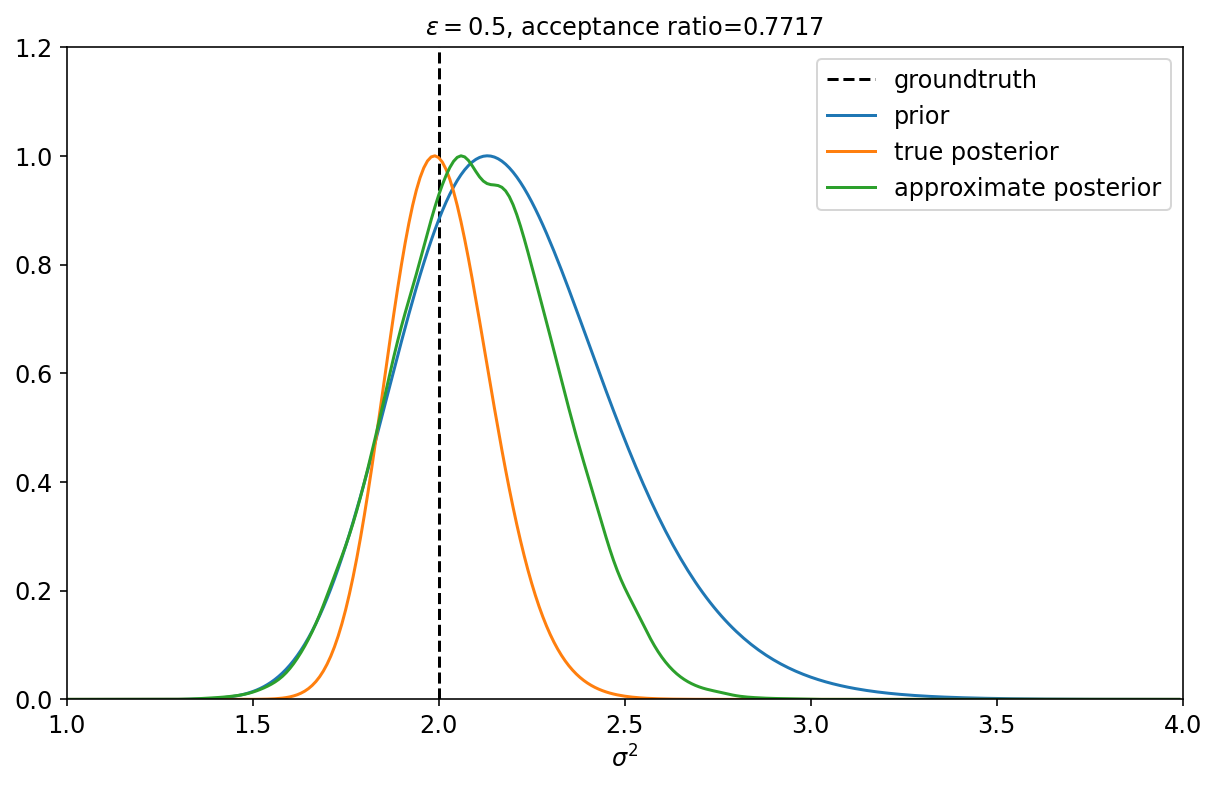

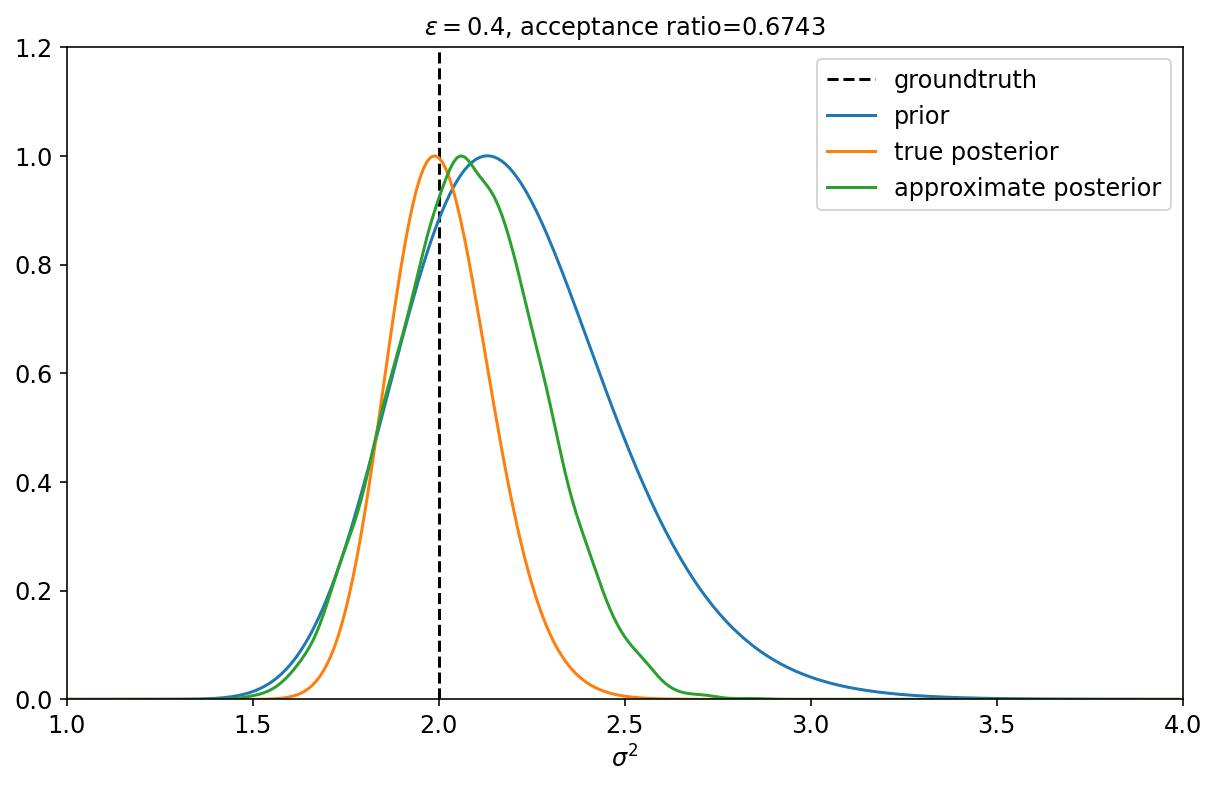

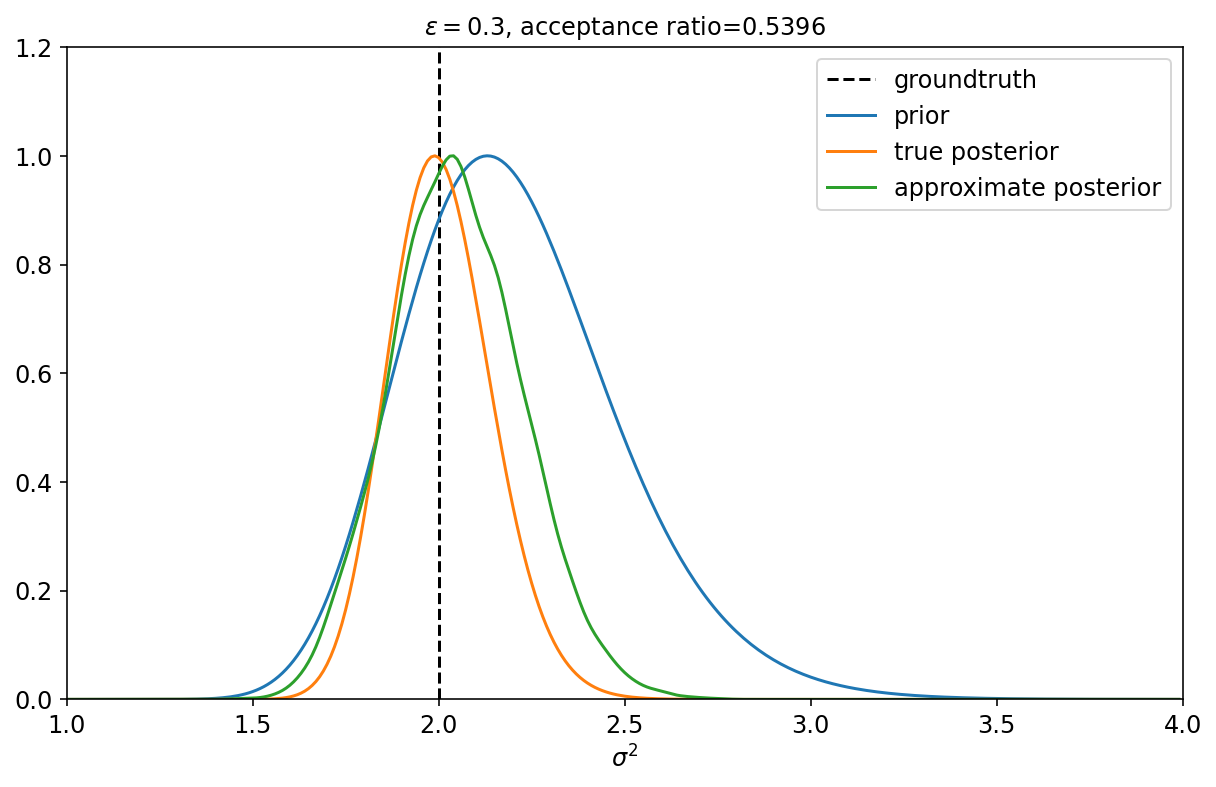

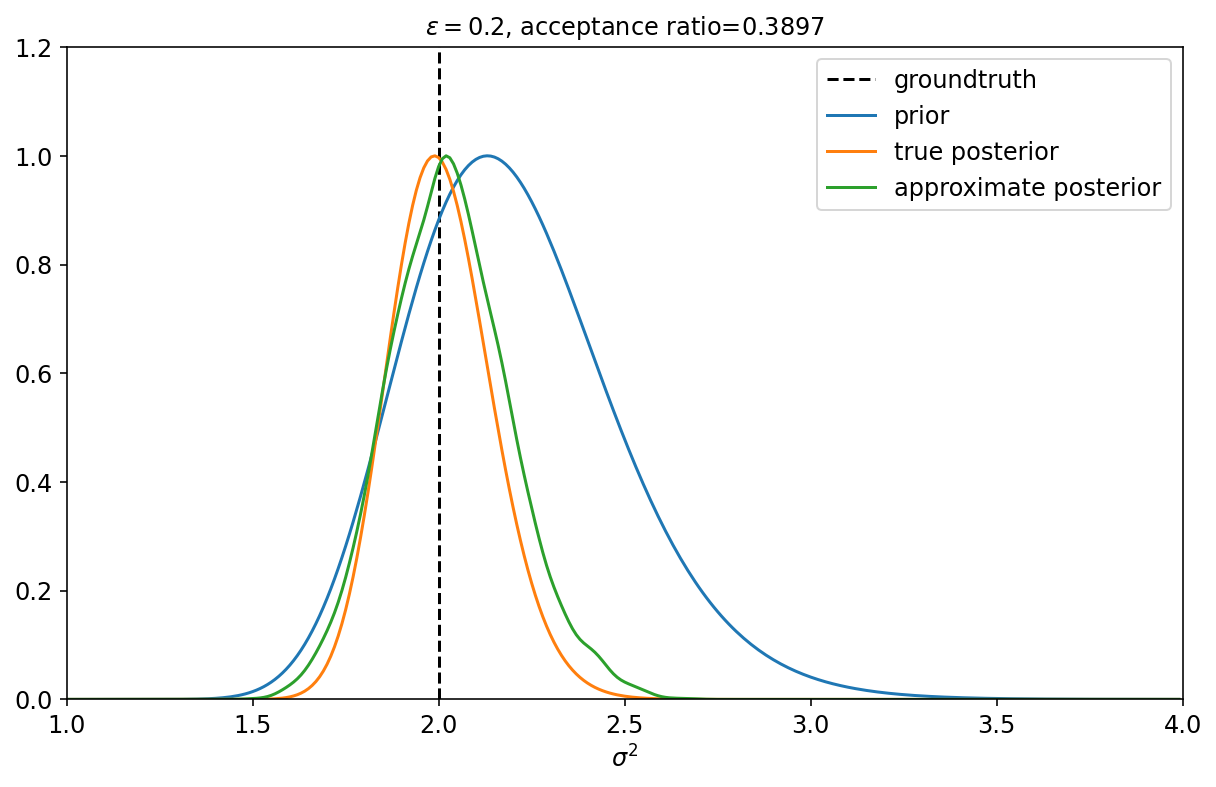

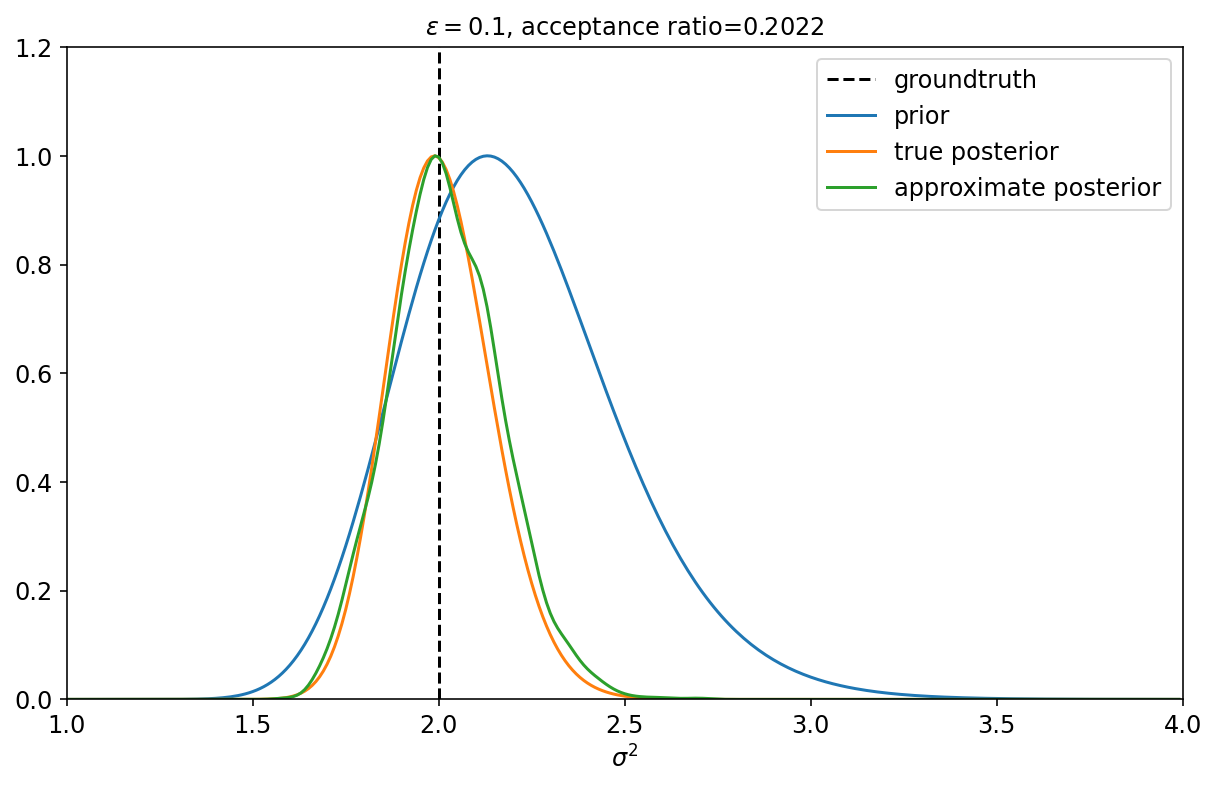

In [11]:
Nsims = 10000

for epsilon in [0.5, 0.4, 0.3, 0.2, 0.1]:
    
    samples = rejection_abc(epsilon, Nsims)
    
    fraction_accepted = float(len(samples)) / Nsims

    # kernel density estimation of the approximate posterior
    kernel = gaussian_kde(samples)

    # produce a plot
    plt.figure(figsize=(10, 6))
    plt.xlim([a, b])
    plt.xlabel("$\sigma^2$")
    plt.ylim([0, 1.2])
    plt.plot([groundtruth, groundtruth],[0, 1.2], linestyle='--', color='black', label="groundtruth")
    plt.plot(x, prior.pdf(x)/prior.pdf(x).max(), label="prior")
    plt.plot(x, posterior.pdf(x)/posterior.pdf(x).max(), label="true posterior")
    plt.plot(x, kernel.evaluate(x)/kernel.evaluate(x).max(), label="approximate posterior")
    plt.title("$\\varepsilon=" + str(epsilon) + "$, acceptance ratio=" + str(fraction_accepted))
    plt.legend()
    plt.show()

## Benchmark

In [1]:
def distance(sim, data):
    return np.sqrt(np.sum((sim - data) * (sim - data)))

In [3]:
def rejection_sampler(obs_data, prior, simulator, summary_stat, epsilon, Nsims):

    samples = []
    obs_sumstat = summary_stat(obs_data)  # observed data summary statistic

    for i in range(Nsims):
        # draw theta from prior
        theta = prior.rvs(size=1)
        # simulated data given a realization of drawn theta
        sim_data = simulator(theta)
        # simulated data summary statistic
        sim_sumstat = summary_stat(sim_data)
        # keep or discard simulation
        if distance(sim_sumstat, obs_sumstat) < epsilon:
            samples.append(theta)

    # compute acceptance ratio
    accept_ratio = float(len(samples)) / Nsims
    # kernel density estimation of the approximate posterior
    kernel = gaussian_kde(np.array(samples).T[0])

    return kernel, accept_ratio

In [4]:
def rejection_sampler_vectorized(obs_data, prior, simulator, summary_stat, epsilon=0.5, Nsims=1000):
    # observed data summary statistic
    obs_sumstat = summary_stat(obs_data)
    # draw thetas from prior
    thetas = prior.rvs(size=Nsims)
    # simulated data given a realization of drawn theta
    sim_data = [simulator(theta) for theta in thetas]
    # summary stat of simulated data
    sim_sumstats = [summary_stat(sim) for sim in sim_data]
    # rejection sampler
    samples = [[thetas[i]] for i, sim_sumstat in enumerate(
        sim_sumstats) if distance(sim_sumstat, obs_sumstat) < epsilon]
    # compute acceptance ratio
    accept_ratio = float(len(samples)) / Nsims
    # kernel density estimation of the approximate posterior
    kernel = gaussian_kde(np.array(samples).T[0])

    return kernel, accept_ratio

In [5]:
# define simulator model
def simulator(var):
    return norm(loc=0., scale=np.sqrt(var)).rvs(size=Nsamp)

In [6]:
# define summary statistic (this particular is sufficient for normal model)
def summary_stat(data):
    return np.var(data)

In [24]:
# observed data (likelihood)
Nsamp = 500
groundtruth = 2.
likelihood = norm(loc=0., scale=np.sqrt(groundtruth))
obs_data = likelihood.rvs(size=Nsamp)

# prior
alpha = 60
beta = 130
prior = invgamma(alpha, loc=0, scale=beta)

a = 1
b = 4
x = np.arange(a, b, 0.01)

# additional parameters
Nsims = 10000
epsilon = 0.2

In [28]:
%%timeit
# Rejection sampler unvectorized
kernel1, accept_ratio1 = rejection_sampler(obs_data, prior, simulator, summary_stat, epsilon, Nsims)

6.55 s ± 205 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [29]:
%%timeit
# Rejection sampler vectorized
kernel2, accept_ratio2 = rejection_sampler_vectorized(obs_data, prior, simulator, summary_stat, epsilon, Nsims)

5.41 s ± 65.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [30]:
kernel1, accept_ratio1 = rejection_sampler(obs_data, prior, simulator, summary_stat, epsilon, Nsims)
print(accept_ratio1)
print(kernel1.evaluate(x).mean())

0.8716
0.33333333333333237


In [31]:
kernel2, accept_ratio2 = rejection_sampler_vectorized(obs_data, prior, simulator, summary_stat, epsilon, Nsims)
print(accept_ratio2)
print(kernel2.evaluate(x).mean())

0.8732
0.33333333333333237


## With Numpy

In [6]:
import numpy as np
import scipy.stats as st
import numba
import matplotlib.pyplot as plt

In [7]:
# Number of very attractive individuals
n = np.round(0.112 * 2972).astype(int)

# Number of male births
m = np.round(0.44 * n).astype(int)

print('Number of very attractive individuals:', n)
print('Number of male births:', m)

Number of very attractive individuals: 333
Number of male births: 147


In [8]:
def simulate_data_binomial_no_numba(p, n):
    '''
    Return number of successes in n trials,
    each with success probability p.
    '''
    data = np.random.rand(n)
    return np.sum(data < p)


@numba.jit(nopython=True)
def simulate_data_binomial(p, n):
    '''
    Return number of successes in n trials,
    each with success probability p.
    '''
    data = np.random.rand(n)
    return np.sum(data < p)

In [9]:
@numba.jit(nopython=True)
def sample_prior_beta(a, b, n_draws=1):
    '''
    Return n_draws samples from a beta distribution
    defined by shape parameters a and b.
    '''
    return np.random.beta(a, b, size=n_draws)

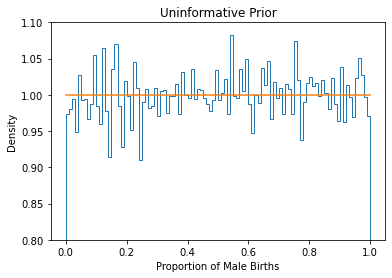

In [16]:
# Set parameters for uninformative uniform prior
a_u = 1
b_u = 1

# Draw samples from uninformative prior
samples_u = sample_prior_beta(a_u, b_u, n_draws=100000)  # a = b = 1 => beta(a, b) -> uniform(a, b)

# Compute true distribution
x_smooth = np.linspace(0, 1, 200)
pdf = st.beta.pdf(x_smooth, a=a_u, b=b_u)

plt.hist(samples_u, bins=100, density=True, histtype='step')
plt.plot(x_smooth, pdf)
plt.title("Uninformative Prior")
plt.xlabel("Proportion of Male Births")
plt.ylabel("Density")
plt.ylim(0.8, 1.1)
plt.show()

Mean value: 0.5175983436853002


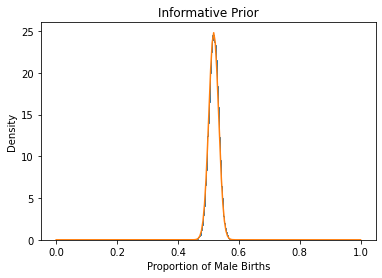

In [19]:
# Set parameters for informative prior
a_i = 500
b_i = 466

# Draw samples from informative prior
samples_i = sample_prior_beta(a_i, b_i, n_draws=100000)

# Compute true distribution
pdf = st.beta.pdf(x_smooth, a=a_i, b=b_i)
print('Mean value:', st.beta.mean(a_i, b_i))

plt.hist(samples_i, bins=100, density=True, histtype='step')
plt.plot(x_smooth, pdf)
plt.title("Informative Prior")
plt.xlabel("Proportion of Male Births")
plt.ylabel("Density")
plt.show()

In [20]:
def sample_posterior(sample_prior, simulate, observed, n_draws=100,
                     prior_args=(), simulate_args=()):
    '''
    Take n_draws samples from posterior distribution using ABC, where
    sample_prior(*prior_args) should generate a single set of
    parameter values param and simulate(param, *simulate_args)
    should simulate a result that can be compared with observed.
    '''
    samples = np.zeros((n_draws, len(sample_prior(*prior_args))))
    for i in range(n_draws):
        while True:
            param = sample_prior(*prior_args)
            if simulate(param, *simulate_args) == observed:
                samples[i, :] = param
                break
    return samples.squeeze()

In [21]:
%%timeit
# Likelihood without numba
post_i = sample_posterior(sample_prior_beta,
                          simulate_data_binomial_no_numba,
                          observed=m, n_draws=100,
                          prior_args=(a_i, b_i),
                          simulate_args=(n, ))

409 ms ± 31.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
%%timeit
# Likelihood with numba
post_i = sample_posterior(sample_prior_beta, simulate_data_binomial,
                          observed=m, n_draws=100,
                          prior_args=(a_i, b_i),
                          simulate_args=(n, ))

139 ms ± 14.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [23]:
%%time
# Sample posterior with uninformative prior
post_u = sample_posterior(sample_prior_beta, simulate_data_binomial,
                          observed=m, n_draws=10000,
                          prior_args=(a_u, b_u),
                          simulate_args=(n, ))

CPU times: user 9.64 s, sys: 38.3 ms, total: 9.68 s
Wall time: 9.67 s


In [24]:
%%time
# Sample posterior with informative prior
post_i = sample_posterior(sample_prior_beta, simulate_data_binomial,
                          observed=m, n_draws=10000,
                          prior_args=(a_i, b_i),
                          simulate_args=(n, ))

CPU times: user 13.6 s, sys: 24.4 ms, total: 13.6 s
Wall time: 13.6 s


Posterior (Uninformative Prior)
2.5th percentile:	 0.3891567064505945
Median:			 0.4419803941716475
97.5th percentile:	 0.49627730377180856

Posterior (Informative Prior)
2.5th percentile:	 0.47154562987216575
Median:			 0.4983191947573188
97.5th percentile:	 0.5250490663573859


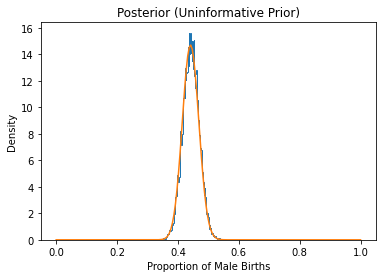

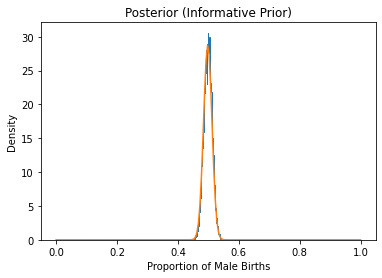

In [25]:
# Analyze samples from posterior with uninformative prior
print('Posterior (Uninformative Prior)')
print('2.5th percentile:\t', np.percentile(post_u, 2.5))
print('Median:\t\t\t', np.median(post_u))
print('97.5th percentile:\t', np.percentile(post_u, 97.5))

# Analyze samples from posterior with informative prior
print('\nPosterior (Informative Prior)')
print('2.5th percentile:\t', np.percentile(post_i, 2.5))
print('Median:\t\t\t', np.median(post_i))
print('97.5th percentile:\t', np.percentile(post_i, 97.5))

# Compute true distributions
pdf_u = st.beta.pdf(x_smooth, a=m+a_u, b=n-m+b_u)
pdf_i = st.beta.pdf(x_smooth, a=m+a_i, b=n-m+b_i)

plt.hist(post_u, bins=100, density=True, histtype='step')
plt.plot(x_smooth, pdf_u)
plt.title("Posterior (Uninformative Prior)")
plt.xlabel("Proportion of Male Births")
plt.ylabel("Density")
plt.show()

plt.hist(post_i, bins=100, density=True, histtype='step')
plt.plot(x_smooth, pdf_i)
plt.title("Posterior (Informative Prior)")
plt.xlabel("Proportion of Male Births")
plt.ylabel("Density")
plt.show()

https://github.com/scipy/scipy/blob/master/scipy/stats/kde.py